Imports

In [8]:
from models import ff_eucl
import ff_hyp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
from torch.utils.tensorboard import SummaryWriter
torch.cuda.is_available()

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

CUDA check

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Data Transformation

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

Training and Test data from MNIST data set

In [11]:
train_set = datasets.KMNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
test_set = datasets.KMNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

size = len(train_set)
print(size)

train_data, val_data = torch.utils.data.random_split(train_set, [int(size-size*0.2), int(size*0.2)])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle= True, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle= True, num_workers=6, pin_memory=True)

60000


Initializing the model

Hyperparameters

Optimizer

In [12]:

# time0 = time()

# epochs = 10
# for e in range(epochs):
#     running_loss = 0
#     for images, labels in trainloader:
#         images, labels = images.to(device), labels.to(device)
#         # Flatten MNIST images into a 784 long vector
#         images = 0.0357*images.view(images.shape[0], -1)
    
#         # Training pass
#         optimizer.zero_grad()
        
#         output = model(images)
#         loss = criterion(output, labels)
        
#         #backpropagation
#         loss.backward()
        
#         #Weight optimization
#         optimizer.step()
        
#         running_loss += loss.item()
#     else:
#         print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
# print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [13]:
### Single prediction function
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### Training function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    total_correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        #images = ball.projx(images.view(images.shape[0], -1))
        # Training pass
        optimizer.zero_grad()
        # for param in model.parameters():
        #     param.grad = None

        output = model(images)
        loss = criterion(output, labels)  
        train_loss += loss.item()
        total_correct += get_num_correct(output, labels)
        #backpropagation
        loss.backward()      
        #Weight optimization
        optimizer.step()  

    return train_loss, total_correct

### Validation function
def val_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for  images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            #images = ball.projx(images.view(images.shape[0], -1))
            output = model(images)
            loss = criterion(output, labels)  
            val_loss += loss.item()
            val_correct += get_num_correct(output, labels)
    
    return val_loss, val_correct



### Model evaluation
def model_eval(model, epochs, trainloader, valloader, optimizer, criterion):
    tb = SummaryWriter()
    t_loss = []
    v_loss = []
    t_accuracy = []
    v_accuracy = []
    epoch_values = []
    for epoch in range(epochs):
        train_loss, total_correct = train_epoch(model, trainloader, optimizer, criterion) 
        t_loss.append(train_loss)
        t_accuracy.append(total_correct/len(train_data))
        val_loss, val_correct = val_epoch(model, valloader, criterion)
        v_loss.append(val_loss)
        v_accuracy.append(val_correct/len(val_data))
        epoch_values.append(epoch)
        
        tb.add_scalar("Training Loss", train_loss, epoch)
        tb.add_scalar("Validation Loss", val_loss, epoch)
        tb.add_scalar("Training Accuracy", total_correct/len(train_data), epoch)
        tb.add_scalar("Validation Accuracy", val_correct/len(val_data), epoch)
        print("epoch:", epoch, "training loss:",train_loss, "validation loss:", val_loss,
        "training accuracy:", total_correct/len(train_data), "validation accuracy:", val_correct/len(val_data))


    return t_loss, v_loss, t_accuracy, v_accuracy, epoch_values

In [14]:
#model = ff_eucl.EuclFF(784, 512, 256, 10, nn.ReLU())
model = ff_hyp.HypFF(784, 512, 256, 10)
print(model)

epochs = 10
#Hyperparameter tuning
#hparams_tune(epochs)
#Model evaluation
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=lr, momentum=0.9)
t_loss ,v_loss, t_accuracy, v_accuracy, epoch_values = model_eval(model, epochs, trainloader, valloader, optimizer, criterion)

HypFF(
  (act_fn): ReLU()
  (fc1): MobLinear(in_features=784, out_features=512, bias=True)
  (fc2): MobLinear(in_features=512, out_features=256, bias=True)
  (fc3): MobLinear(in_features=256, out_features=10, bias=True)
)
epoch: 0 training loss: 1572.4074251651764 validation loss: 319.785316824913 training accuracy: 0.397 validation accuracy: 0.7929166666666667
epoch: 1 training loss: 1170.9979574680328 validation loss: 284.86343109607697 training accuracy: 0.8960208333333334 validation accuracy: 0.9283333333333333
epoch: 2 training loss: 1116.6586233377457 validation loss: 280.54765594005585 training accuracy: 0.9525416666666666 validation accuracy: 0.9464166666666667
epoch: 3 training loss: 1100.3390508890152 validation loss: 278.2570513486862 training accuracy: 0.9718333333333333 validation accuracy: 0.9540833333333333
epoch: 4 training loss: 1090.6885832548141 validation loss: 277.06921434402466 training accuracy: 0.9813333333333333 validation accuracy: 0.9570833333333333
epoch: 5 

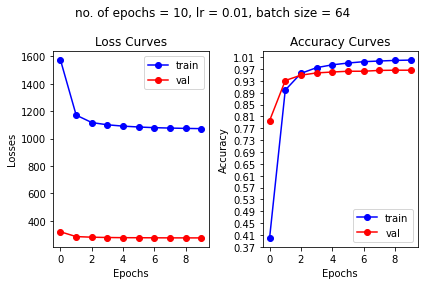

In [18]:
from matplotlib.ticker import FormatStrFormatter

fig , (ax0, ax1) = plt.subplots(1, 2)

# ax0 = fig.add_subplot(121, title="Loss curves")
# ax1 = fig.add_subplot(122, title="Accuracy curves")
ax0.set_title('Loss Curves')
ax1.set_title('Accuracy Curves')
ax0.plot(epoch_values, t_loss, 'bo-', label='train')
ax0.plot(epoch_values, v_loss, 'ro-', label='val')
ax1.plot(epoch_values, t_accuracy, 'bo-', label='train')
ax1.plot(epoch_values, v_accuracy, 'ro-', label='val')


start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(start, end, 0.04))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax0.set_xlabel('Epochs')
ax1.set_xlabel('Epochs')
ax0.set_ylabel('Losses')
ax1.set_ylabel('Accuracy')
ax0.legend()
ax1.legend()

fig.suptitle('no. of epochs = {}, lr = {}, batch size = 64'.format(epochs, lr))
fig.tight_layout()

In [16]:
# images, labels = next(iter(valloader))
# #images, labels = images.to(device), labels.to(device)

# img = 0.0357*images[0].view(1, 784)
# img_gpu = img.to(device)
# with torch.no_grad():
#     out = model(img_gpu)

# ps = out.cpu()
# print(ps)
# probab = list(ps.numpy()[0])
# print(probab)
# print("Predicted Digit =", probab.index(max(probab)))
# helper.view_classify(img.view(1, 28, 28), ps)

In [17]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

KeyboardInterrupt: 

Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.